# Exchange rate forecasting

Forecasting exchange rates involves predicting future values of one currency in terms of another currency.In this notebook we are going to deploy several ML models to forecast the price of INR(Indian Rupee) in terms of USD(United States Dollar).

**Importing necessary libraries**

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import LSTM, Dense

**Data Preprocessing**

We are going to use historical data of USD/INR.

This step involves loading and preprocessing that data. We handle missing values and change it to a desired format for further analysis.

/tmp/ipykernel_20154/1315382787.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].fillna(df['Price'].mean(), inplace=True)


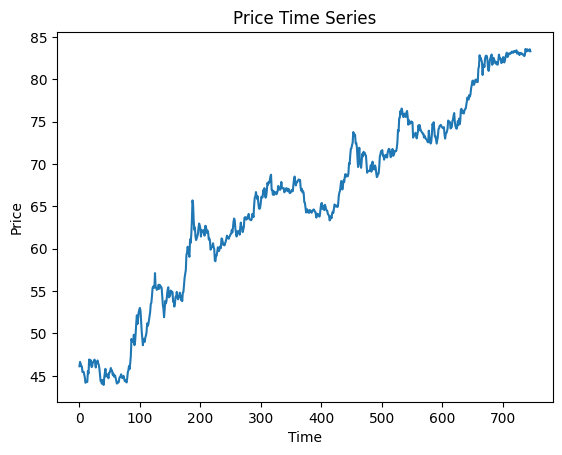

In [45]:
df = pd.read_csv(r'USD_INR Historical Data (2).csv')
missing_values = df['Price'].isnull().sum()
df['Price'].fillna(df['Price'].mean(), inplace=True)

df = df[::-1].reset_index(drop=True)
plt.plot(df['Price'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Time Series')
plt.show()

**Feature Engineering**

We start by deploying a Linear Regression model as Time is an independent variable and Price is the only dependent Feature.

In [46]:
X = np.array(df.index).reshape(-1, 1) 
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nMean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)
next_price_linear_regression = model.predict(np.array([len(df)]).reshape(1, -1))

print("Predicted price for the next data point after the last known price using Linear Regression:", next_price_linear_regression[0])



Mean Squared Error (MSE): 8.891420243092215
Root Mean Squared Error (RMSE): 2.9818484607860634
R-squared (R2) Score: 0.9326617398775061
Predicted price for the next data point after the last known price using Linear Regression: 84.06727333919177


The results for our Linear Regression model shows that MSE and RMSE<10 and R^2 Score >0.95 which signifies that our model is fairly good fit.

The forecasted price from our Linear Regression model is 84.06727333919177

Now we are going to deploy a LSTM model as Price follows a trend with Time.

In [52]:

target_column = "Price"
scaler = MinMaxScaler(feature_range=(0, 1))
df[target_column] = scaler.fit_transform(df[[target_column]])
look_back = 30  
sequences = []
for i in range(look_back, len(df)):
    sequence = df[target_column][i-look_back:i]
    sequences.append(sequence)
sequences = np.array(sequences)
train_size = int(len(sequences) * 0.8) 
train_data, test_data = sequences[:train_size], sequences[train_size:]
X_train = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
X_test = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
model.fit(X_train, train_data[:, -1], epochs=100, batch_size=32) 
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)
actual_prices = df[target_column][look_back + train_size:] 
rmse = mean_squared_error(actual_prices, test_predictions)
mae = mean_absolute_error(actual_prices, test_predictions)
r2sc= r2_score(actual_prices, test_predictions)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(r2sc)

Epoch 1/100


/usr/local/python/3.10.13/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1180
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0103
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.3522e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.3317e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.6836e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - lo

According to the results of LSTM, MSE and RMSE<0.05 and R^2 Score>0.95 hence due to having less MSE and RMSE than Linear Regression model we can conclude that LSTM is better at forecasting in this context. 

In [48]:
last_sequence = X_test[-1]
last_sequence = last_sequence[-30:]
last_sequence = last_sequence.reshape(1, 30, 1)
next_day_prediction = model.predict(last_sequence)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
print("Forecast for the next day:", next_day_prediction[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Forecast for the next day: 83.10529


The forecast according to LSTM is 83.10529

Now we deploy a KNeighbors Regression model.

Predicted price for the next data point after the last known price using KNN: 99.52946516377945


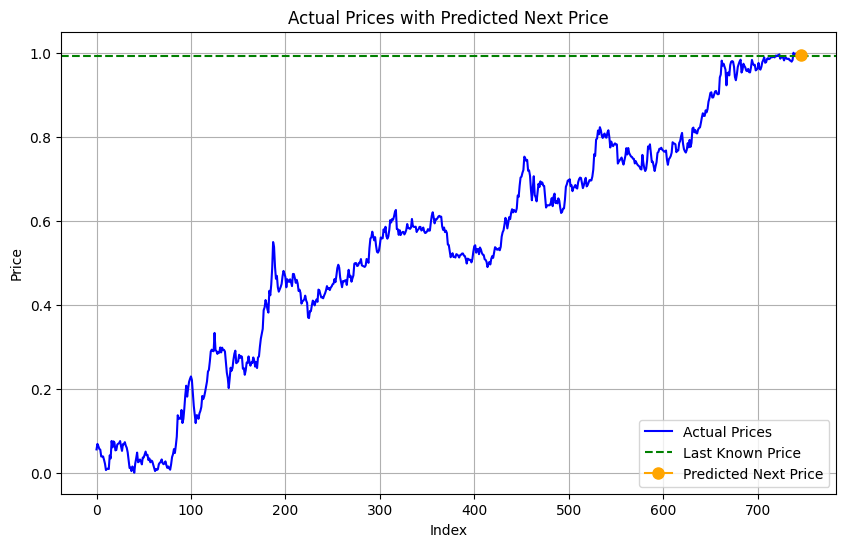

In [49]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
last_known_price = df['Price'].iloc[-1]
X_train = np.arange(len(df)).reshape(-1, 1)
y_train = df['Price']
k = 5
knn_model = KNeighborsRegressor(n_neighbors=k)
knn_model.fit(X_train, y_train)
next_price = knn_model.predict([[len(df)]])

print("Predicted price for the next data point after the last known price using KNN:", next_price[0]*100)
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Price'], color='blue', label='Actual Prices')
plt.axhline(y=last_known_price, color='green', linestyle='--', label='Last Known Price')
plt.plot(df.index[-1], next_price, marker='o', markersize=8, color='orange', label='Predicted Next Price')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual Prices with Predicted Next Price')
plt.legend()
plt.grid(True)
plt.show()


The forecasted price according to Kneighbors Regression is 99.52946516377945

In [50]:
from sklearn.metrics import mean_squared_error, r2_score
y_train_pred = knn_model.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_train_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 7.1232905117102e-05
Root Mean Squared Error (RMSE): 0.008439958833851145
R-squared (R2) Score: 0.9990900192129067


The R^2 value is 0.99 which is the closest we have achieved till now to 1.


Hence the forecasting of Kneighbors Regression is nearly perfect and we can conclude Kneighbors Regression model is the best fit for our data